# Project 1 What Makes You Happy?
### _Author: Fei Zheng_

## 0. Preparation

A general descriptions for the libraries from official documents:  
+ `sys`: This module provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter.
+ `warning`: Warning messages are typically issued in situations where it is useful to alert the user of some condition in a program, where that condition (normally) doesn’t warrant raising an exception and terminating the program.
+ `re`: This module provides regular expression matching operations similar to those found in Perl.
+ `random`: This module implements pseudo-random number generators for various distributions.
+ `pandas`: Pandas provides high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
+ `numpy`: NumPy is the fundamental package for scientific computing in Python.
+ `matplotlib`: Matplotlib is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.
+ `nltk`: NLTK is a leading platform for building Python programs to work with human language data.  
  
There are some other libraries and functions I will use later. Following the general rule, I will import them when necessary, where the description will be attached also.

In [1]:
# load libraries and functions
from __future__ import print_function
import sys
import warnings
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

In [2]:
# append the function folder to the system path
sys.path.append('../lib')
warnings.simplefilter("ignore", UserWarning)

In [3]:
# print the python version
print(sys.version)

3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


## 1. Load the data and have a general view

In [4]:
# read the data from subfolder `data` in the project
hm_data = pd.read_csv('../data/HappyDB/happydb/data/cleaned_hm.csv')

First, let's geta general sense of the data!  
For convenience, here is a variables' descriotion copied from official github documents.  
+ __hmid (int)__: Happy moment ID
+ __wid (int)__: Worker ID
+ __reflection_period (str)__: Reflection period used in the instructions provided to the worker (3m or 24h)
+ __original_hm (str)__: Original happy moment
+ __cleaned_hm (str)__: Cleaned happy moment
+ __modified (bool)__: If True, original_hm is "cleaned up" to generate cleaned_hm (True or False)
+ __predicted_category (str)__: Happiness category label predicted by our classifier (7 categories. Please see the reference for details)
+ __ground_truth_category (str)__: Ground truth category label. The value is NaN if the ground truth label is missing for the happy moment
+ __num_sentence (int)__: Number of sentences in the happy moment

In [5]:
hm_data.head(10)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection
5,27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
6,27679,195,24h,"I made a new recipe for peasant bread, and it ...","I made a new recipe for peasant bread, and it ...",True,1,NaN,achievement
7,27680,740,24h,I got gift from my elder brother which was rea...,I got gift from my elder brother which was rea...,True,1,NaN,affection
8,27681,3,24h,YESTERDAY MY MOMS BIRTHDAY SO I ENJOYED,YESTERDAY MY MOMS BIRTHDAY SO I ENJOYED,True,1,NaN,enjoy_the_moment
9,27682,4833,24h,Watching cupcake wars with my three teen children,Watching cupcake wars with my three teen children,True,1,NaN,affection


Obviously, `cleaned_hm` must be my main focus.  
There are so many missing values in `ground_truth_category` that makes it difficult to deal with.  
Luckily, we have `predicted_category` which has 7 categories. This might provide some useful information!  
And also, official database provides some affiliated `.csv` documents(e.g., `senselabel.csv`, `pets-dict.csv`) which might be useful later.   

## 2. Text Preprocessing

Whatever, let's first process `cleaned_hm`.  
Generally, there are several standard steps for text preprocessing. I summarize below:    
1. Transform sentences into words, which is also called `tokenization`.  
2. Tag the part of speech, which is called `POS Tagging`(Optional).   
3. Remove the punctuation and non-alpha words(e.g. numbers, whitespace).  
4. Correct the spelling mistakes.  
5. Transform all words into lowercase. 
6. `Lemmatization/Stemming`.  
7. Remove too short words and stopwords.

#### Step1. Tokenization

In [6]:
hm = hm_data['cleaned_hm'].copy()
token_hm = [nltk.word_tokenize(sent) for sent in hm]

#### Step2. POS tagging

In [7]:
pos_hm = [nltk.pos_tag(sent) for sent in token_hm]

#### Step3. Remove the punctuation and non-alpha words

`string.punctuation`: This is a string of ASCII characters which are considered punctuation characters in the C locale.  
!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~

In [8]:
from string import punctuation
punct_hm = [[tup for tup in sent if re.search(r'\D+', tup[0]) and tup[0] not in list(punctuation) 
            and tup[0] not in ["'s","'d","'ll",'',"'m","'ve"]]
             for sent in pos_hm]

#### Step4. Check the spelling mistakes

`pyenchant`: This package provides a set of Python language bindings for the Enchant spellchecking library.[@rfk/pyenchant](https://github.com/rfk/pyenchant)

In [9]:
import enchant
d = enchant.Dict('en_US') # US English
check_hm = [[d.check(tup[0]) for tup in sent] for sent in punct_hm]
num_mis = len([word for sent in check_hm for word in sent if word == False])
print('There are {0} spelling mistakes. The mistake rate is {1:.2f}%'.format(num_mis,
    100 * num_mis/len([word for sent in check_hm for word in sent])))

There are 34889 spelling mistakes. The mistake rate is 1.90%


Let's have a look at what kind of the spelling mistakes they are.

In [10]:
# get all the indexes for the spelling mistake(False)
indexes = [[i,j] for i in range(len(check_hm)) for j,x in enumerate(check_hm[i]) if x == False]

# randomly choose 10 some spelling mistakes
random.seed(1)
for i in range(10):
    choice = random.choice(range(len(indexes)))
    idx1 = indexes[choice][0]
    idx2 = indexes[choice][1]
    print('The mistake word is: {0}.\nThe sentence is: {1} \n'.format(punct_hm[idx1][idx2][0], hm[idx1]))

The mistake word is: glitched.
The sentence is: I got a free pack of cigarettes because the computer glitched out when I went to pay. 

The mistake word is: n't.
The sentence is: My knee didn't hurt all day. 

The mistake word is: Overwatch.
The sentence is: I managed to properly figure out how a recent update to Overwatch would impact the DPS of various characters, and how that might affect balance. 

The mistake word is: cryptocurrency.
The sentence is: The coin on a cryptocurrency exchange that I was hoping would drop in price so I could buy it, droppedd a lot in price and I was able to buy a lot of it for cheap. 

The mistake word is: harvard.
The sentence is: My kids will be able to see thier farther go to harvard 

The mistake word is: Veenhoven.
The sentence is: happiness in terms of living a good life, or flourishing, rather than simply as an emotion. Happiness in this sense was used to translate the Greek eudaimonia, and is still used in virtue ethics. There has been a transit

From the random examples above, some mistakes come from abbreviation(e.g. `don't` will be tokenized into `do` and `n't`) which is very meaningful and can be dealt with by `POS tagging` in `nltk`. Some other mistakes come from special words(e.g `chipotle`, `ramen`).  
  
It's tough to deal with such spelling problems. Considering the low misspelling rate, we could just ignore them.  

#### Step5. Transform to lowercase

In [11]:
lower_hm = [[(tup[0].lower(), tup[1]) for tup in sent] for sent in punct_hm]

#### Step6. Lemmatization

In [12]:
# def the function that convert the POS from original form to consistent form
from nltk.corpus import wordnet
def get_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [13]:
wnl = nltk.WordNetLemmatizer()
lemma_hm = [[(wnl.lemmatize(tup[0], get_pos(tup[1])), tup[1]) for tup in sent]for sent in lower_hm]

#### Step6. Remove too short words and stopwords

In [14]:
# remove words whose length < 3 and remove stopwords
from nltk.corpus import stopwords
words = stopwords.words('english') + ["happy","ago","yesterday","lot","today","month","last","week","past",
                                     "get","make","day","n't","take","year","time"]
stop_hm = [[tup for tup in sent 
            if len(tup[0]) >= 3 and tup[0] not in words and not re.search(r"^\'[a-zA-Z]", tup[0])] 
           for sent in lemma_hm]

#### Step7. Combine the processed text to the original data and export

In [15]:
hm_data['processed_hm'] = [' '.join([tup[0] for tup in sent]) for sent in stop_hm]
hm_data.to_csv('../output/processed_hm.csv', index=False)

## 3. Explore the Texts

#### Step1. Combine the processed data with demographic data

In [34]:
hm_data = pd.read_csv('../output/processed_hm.csv')
demo_data = pd.read_csv('../data/HappyDB/happydb/data/demographic.csv')
hm_data = hm_data.merge(demo_data, on = 'wid', how = 'inner', copy=False)
hm_data.head(1)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,processed_hm,age,country,gender,marital,parenthood
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection,successful date someone felt sympathy connection,35,USA,m,single,n


#### Step2. Select rows that satisfies specific row conditions and export

In [17]:
# transform Age to integer and count the words
def trans_age(age):
    try:
        return int(float(age))
    except:
        return np.nan
def word_count(words):
    try:
        return len(words.strip().split(' '))
    except:
        return np.nan

hm_data = hm_data.assign(age = hm_data['age'].map(trans_age),
                        word_count = hm_data['processed_hm'].map(word_count))

In [18]:
# filter the rows
hm_data_sub = hm_data.loc[(hm_data['gender'].isin(['m','f'])) &
                     (hm_data['marital'].isin(['single','married','divorced'])) &
                     (hm_data['parenthood'].isin(['n','y'])) &
                     (hm_data['reflection_period'].isin(['3m','24h']))&
                     (hm_data['age'].between(1,100)) &
                     (~hm_data['processed_hm'].isnull()) &
                     (hm_data['word_count'] > 1)
                         ,['wid','original_hm','cleaned_hm','predicted_category',
                          'processed_hm','age','country','gender','marital','parenthood']]

In [19]:
# export
hm_data_sub.to_csv('../output/subset_hm.csv', index = False)

#### Step3. Word Cloud

In [20]:
hm = pd.Series([words for sent in hm_data_sub['processed_hm'] for words in sent.strip().split(' ') ])

Text(0.5, 1.0, 'The 20 most frequent words')

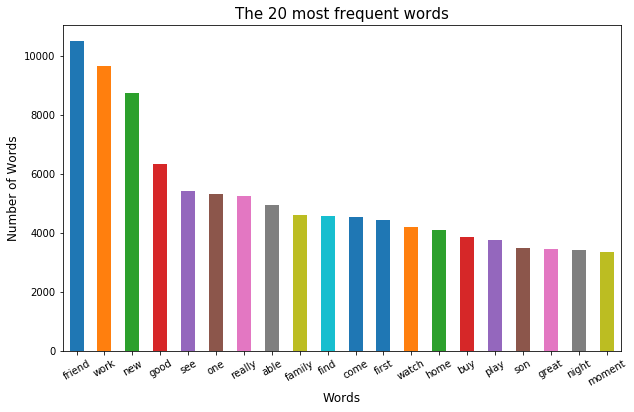

In [25]:
# count
plt.figure(figsize=(10,6))
hm.value_counts(ascending=False)[:20].plot.bar()
plt.xticks(rotation = 30)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Number of Words', fontsize=12)
plt.title('The 20 most frequent words', fontsize=15)

In [26]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(stopwords=STOPWORDS, max_words=50, background_color="white")
wordcloud2 = wordcloud.generate_from_frequencies(dict(hm.value_counts()))

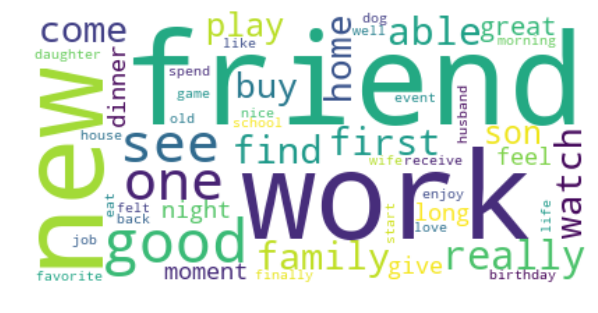

In [27]:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.show()

In [24]:
wordcloud2.to_file('../figs/wordcloud.png')

## 4. Model: Non-negative Matrix Factorization (NMF)

Thanks for the basic code example by @_Aneesha Bakharia_ in the <[Modeling with Scikit Learn](https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730)>

### The First Try

#### Step0. Import functions and data

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
hm_data = pd.read_csv('../output/subset_hm.csv')
hm = hm_data['processed_hm']
hm = [x for x in hm]

#### Step1.  TF-IDF

In [8]:
num_features = 1000
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=num_features)
tfidf = tfidf_vectorizer.fit_transform(hm)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

#### Step2. NMF

In [9]:
num_topics = 20
nmf = NMF(n_components=num_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

In [10]:
# results
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
display_topics(nmf, tfidf_feature_names)

Topic 0:
friend best old meet talk party long hang close lunch
Topic 1:
new job purchase car start phone move try puppy computer
Topic 2:
work finish project receive raise early promotion complete bonus hard
Topic 3:
night wife sleep great morning love wake date girlfriend bed
Topic 4:
play game video win team basketball baseball fun online favorite
Topic 5:
watch movie show favorite episode enjoy season funny netflix one
Topic 6:
dinner nice husband cook delicious girlfriend restaurant tonight pizza chicken
Topic 7:
good really feel job felt like well book life enjoy
Topic 8:
birthday party celebrate gift surprise give brother present mother mom
Topic 9:
find job one finally dollar look lose money store think
Topic 10:
buy car ticket want store house phone shoe one new
Topic 11:
dog walk long park nice morning outside play weather around
Topic 12:
family spend enjoy member vacation trip together moment easter weekend
Topic 13:
eat favorite lunch food delicious restaurant pizza meal cr

It seems there are some very close topics. *So how to decide a **good** number of topics?*

#### Step3. Visualization through t-SNE

In [10]:
W = nmf.fit_transform(tfidf)
H = nmf.components_

In [11]:
threshold = 0.05
idx = np.amax(W, axis=1) > threshold  # idx of doc that above the threshold
W = W[idx]
W.shape

(4985, 20)

In [12]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_nmf = tsne_model.fit_transform(W)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4985 samples in 0.023s...
[t-SNE] Computed neighbors for 4985 samples in 0.552s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4985
[t-SNE] Computed conditional probabilities for sample 2000 / 4985
[t-SNE] Computed conditional probabilities for sample 3000 / 4985
[t-SNE] Computed conditional probabilities for sample 4000 / 4985
[t-SNE] Computed conditional probabilities for sample 4985 / 4985
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.790222
[t-SNE] KL divergence after 1000 iterations: 0.097009


In [13]:
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool

# number of keywords we want show
n_top_words = 5 

# 20 colors
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

In [14]:
nmf_keys = []
for i in range(W.shape[0]):
    nmf_keys.append(W[i].argmax())

In [16]:
topic_summaries = []
for i, topic_dist in enumerate(nmf.components_):
    topic_words = np.array(tfidf_feature_names)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
    topic_summaries.append(' '.join(topic_words)) # append!

In [143]:
title = 'Visualization by t-SNE for 20 topics'
num_example = len(W)

plot_nmf = bp.figure(plot_width=1400, plot_height=1100,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

content = [sent for i, sent in enumerate(hm) if idx[i] == True]
source = bp.ColumnDataSource(data=dict(x = tsne_nmf[:, 0], y = tsne_nmf[:, 1], 
                                       color = colormap[nmf_keys][:num_example],
                                       content = content[:num_example], keys = nmf_keys[:num_example]))

plot_nmf.scatter(x='x', y='y', color = 'color', source = source)


GlyphRenderer(id='15154', ...)

In [144]:
# randomly choose a news (within a topic) coordinate as the crucial words coordinate
topic_coord = np.empty((W.shape[1], 2)) * np.nan
for topic_num in nmf_keys:
    if not np.isnan(topic_coord).any():
        break
    topic_coord[topic_num] = tsne_nmf[nmf_keys.index(topic_num)]

# plot crucial words
for i in range(W.shape[1]):
    plot_nmf.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

# hover tools
hover = plot_nmf.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @keys"}

# save the plot
save(plot_nmf, '../figs/{}.html'.format(title))

/Users/james/anaconda3/lib/python3.6/site-packages/bokeh/io/saving.py:127: UserWarning:

save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN

/Users/james/anaconda3/lib/python3.6/site-packages/bokeh/io/saving.py:140: UserWarning:

save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'



'/Users/james/Desktop/Lectures/GR5243_Applied_Data_Science/Spring2019-Proj1-zhengfei0908/figs/Visualization by t-SNE for 20 topics.html'

In [145]:
from IPython.core.display import HTML
HTML('../figs/Visualization by t-SNE for 20 topics.html')

In [12]:
from TSNE_PLOT import Tsne_Plot
Tsne_Plot(data=hm, num_features=1000, num_topics=15, threshold=0.05, title='try', display=True)

In [11]:
from IPython.core.display import HTML
HTML('../figs/try.html')